In this notebook we explore the opportunities for the qubit MILP

Let's first generate a random qiskit circuit.

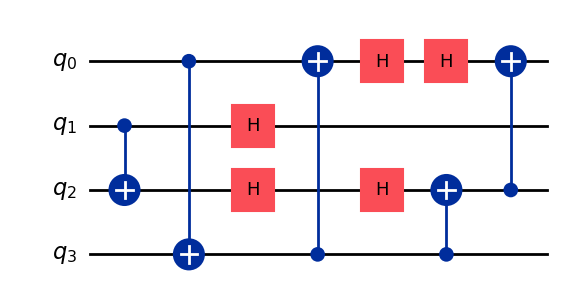

In [17]:
import qiskit.circuit.random
import qiskit.circuit.library.standard_gates

QUBIT_COUNT = 4
NUM_GATES = 10
SEED = 155
MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h"]


random_circuit = qiskit.circuit.random.random_clifford_circuit(num_qubits=QUBIT_COUNT, num_gates=NUM_GATES, seed=SEED, gates=STANDARD_GATE_SET)
random_circuit.draw(output='mpl')

Let's see what are the circuit properties. For that, let's convert circuit to DAG, and then plot the dag.

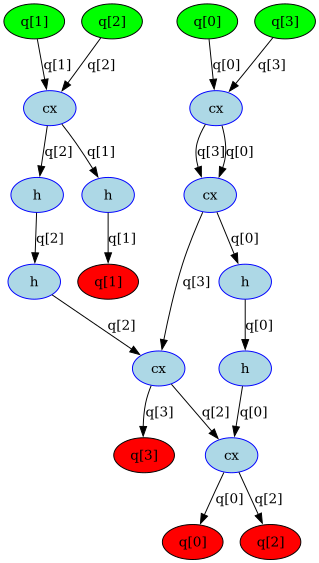

In [18]:
import qiskit.converters
import qiskit.visualization
 
random_circuit_dag = qiskit.converters.circuit_to_dag(random_circuit)
qiskit.visualization.dag_drawer(random_circuit_dag)

Let's check the dot generation actually

In [19]:
random_circuit_dag._to_dot()

'digraph {\n0 ;\n1 ;\n2 ;\n3 ;\n4 ;\n5 ;\n6 ;\n7 ;\n8 ;\n9 ;\n10 ;\n11 ;\n12 ;\n13 ;\n14 ;\n15 ;\n16 ;\n17 ;\n0 -> 9 ;\n2 -> 8 ;\n4 -> 8 ;\n6 -> 9 ;\n8 -> 10 ;\n8 -> 11 ;\n10 -> 12 ;\n9 -> 13 ;\n9 -> 13 ;\n13 -> 14 ;\n12 -> 14 ;\n13 -> 15 ;\n15 -> 16 ;\n14 -> 17 ;\n16 -> 17 ;\n14 -> 7 ;\n11 -> 3 ;\n17 -> 5 ;\n17 -> 1 ;\n}\n'

Okay, pretty useless. Maybe, the edges will help?

In [20]:
list(random_circuit_dag.edges())

[(DAGInNode(wire=<Qubit register=(4, "q"), index=0>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()),
  <Qubit register=(4, "q"), index=0>),
 (DAGInNode(wire=<Qubit register=(4, "q"), index=1>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()),
  <Qubit register=(4, "q"), index=1>),
 (DAGInNode(wire=<Qubit register=(4, "q"), index=2>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()),
  <Qubit register=(4, "q"), index=2>),
 (DAGInNode(wire=<Qubit register=(4, "q"), index=3>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), ca

That's better, but sitll kinda problematic. Maybe let's revert to qasm3.

In [21]:
import qiskit.qasm3


print(qiskit.qasm3.dumps(random_circuit))

OPENQASM 3.0;
include "stdgates.inc";
qubit[4] q;
cx q[1], q[2];
cx q[0], q[3];
h q[2];
h q[1];
h q[2];
cx q[3], q[0];
cx q[3], q[2];
h q[0];
h q[0];
cx q[2], q[0];



Okay, MAYBE NOT. Let's continue fighting with the DAG. Chcecking out the dagdependency. It seems useless for us tbh


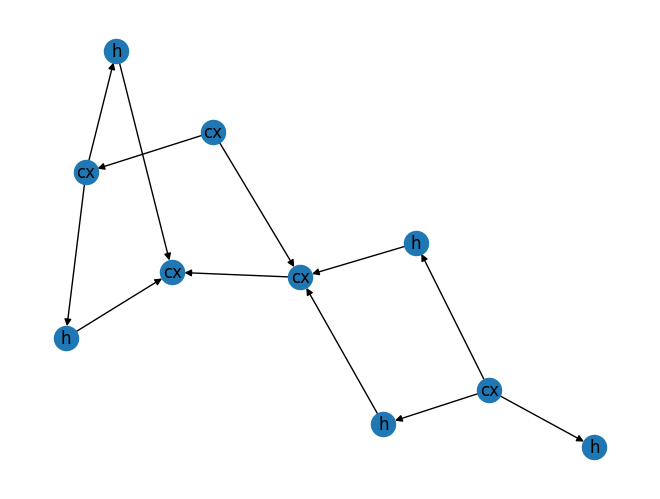

In [22]:
import rustworkx.visualization

random_dag_dependency = qiskit.converters.circuit_to_dagdependency(random_circuit)
random_dag_dependency_rx = random_dag_dependency.to_retworkx()
rustworkx.visualization.mpl_draw(random_dag_dependency_rx, with_labels=True, labels = lambda node: node.name)

random_dag_dependency_rx

Okay, probably the conversion of the original graph is more desired.

In [23]:
random_dag_nodes = list(random_circuit_dag.nodes())
random_dag_nodes

[DAGInNode(wire=<Qubit register=(4, "q"), index=0>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=0>),
 DAGInNode(wire=<Qubit register=(4, "q"), index=1>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=1>),
 DAGInNode(wire=<Qubit register=(4, "q"), index=2>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=2>),
 DAGInNode(wire=<Qubit register=(4, "q"), index=3>),
 DAGOutNode(wire=<Qubit register=(4, "q"), index=3>),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()),
 DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=2>,), cargs=()),
 DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "

Some kind of conversion operation should happen here. Let me invent the internal format of that. Maybe initially, simple graph conversion is valid, because I probably won't need a tailoring for a special operations NOW.

Let's select only operations instrutions, and print them.

In [24]:
import qiskit.dagcircuit.dagnode

for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        print(id(node))

139648988940880
139648988939440
139648988951392
139648988946928
139648988952256
139648988950240
139648988944048
139648988943760
139648988948656
139648988950384


Good, now let's see the edges again.

In [25]:
random_dag_edges = list(random_circuit_dag.edges())

for edge in random_dag_edges:
    print(edge)


(DAGInNode(wire=<Qubit register=(4, "q"), index=0>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()), <Qubit register=(4, "q"), index=0>)
(DAGInNode(wire=<Qubit register=(4, "q"), index=1>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()), <Qubit register=(4, "q"), index=1>)
(DAGInNode(wire=<Qubit register=(4, "q"), index=2>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=1>, <Qubit register=(4, "q"), index=2>), cargs=()), <Qubit register=(4, "q"), index=2>)
(DAGInNode(wire=<Qubit register=(4, "q"), index=3>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=3>), cargs=()), <Qubit regis

Now, let's setup conversion to nx. Let's check also that it is DAG.

In [26]:
import networkx as nx

circuit_dag_routing = nx.DiGraph()
circuit_dag_routing.add_nodes_from(random_dag_nodes)

circuit_dag_edges_nx = [(edge[0], edge[1], {"wire": edge[2]}) for edge in random_dag_edges] # edges in the qiskit formalism are literally in-edge, out-edge and a wire which is the connector
circuit_dag_routing.add_edges_from(circuit_dag_edges_nx)

nx.is_directed_acyclic_graph(circuit_dag_routing)

True

Let's also plot it.

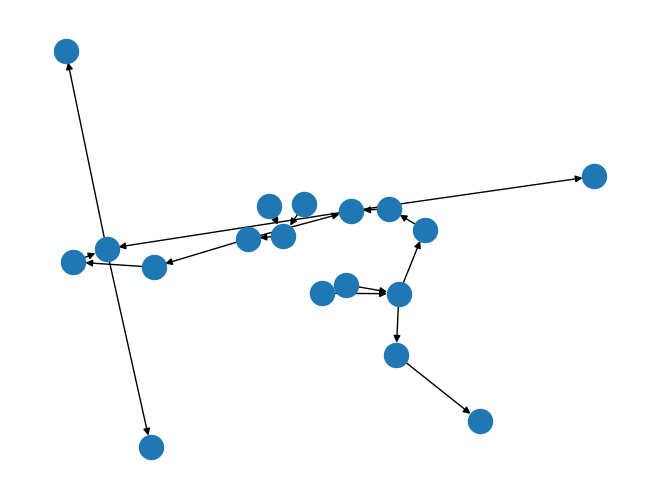

In [27]:
nx.draw(circuit_dag_routing)

Let's draw it a bit better

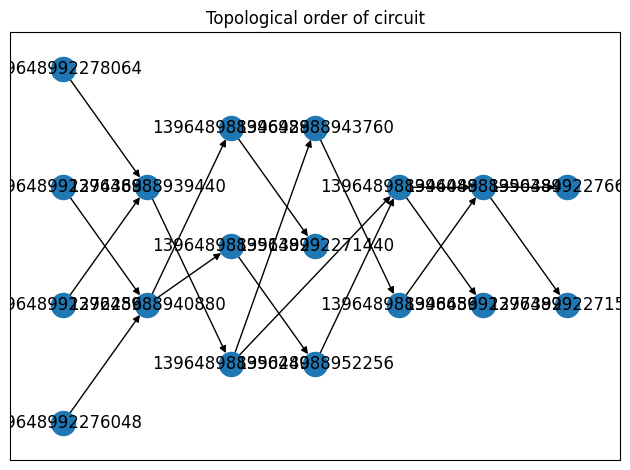

In [28]:
import matplotlib.pyplot as plt

for layer, nodes in enumerate(nx.topological_generations(circuit_dag_routing)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        circuit_dag_routing.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(circuit_dag_routing, subset_key="layer")

fig, ax = plt.subplots()
nx.draw_networkx(circuit_dag_routing, pos=pos, ax=ax)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

Let's then also add normal node labels.

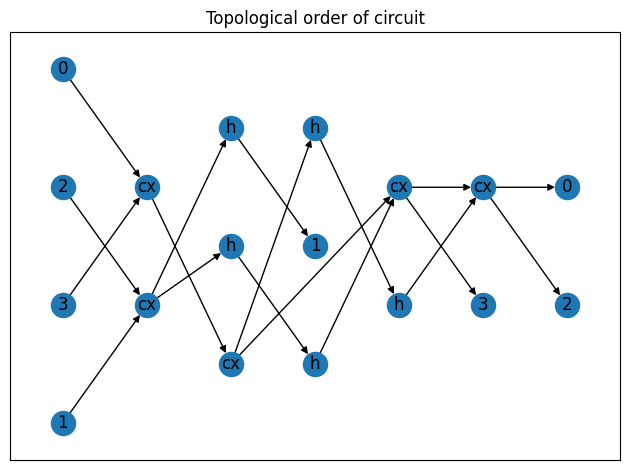

In [29]:
import qiskit.dagcircuit

circuit_labels_by_node = {}
for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        circuit_labels_by_node[node] = node.op.name
    elif isinstance(node, (qiskit.dagcircuit.DAGInNode, qiskit.dagcircuit.DAGOutNode)):
        circuit_labels_by_node[node] = node.wire._index

fig, ax = plt.subplots()
nx.draw_networkx(circuit_dag_routing, pos=pos, ax=ax, labels=circuit_labels_by_node)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

I understood, that I would like to have an intermediate object layer conversion, to make it compatible with other backends. Let's create it with dataclasses.

In [30]:
import dataclasses

@dataclasses.dataclass(frozen=True)
class Qubit:
    is_start: bool
    index: int

@dataclasses.dataclass(frozen=True)
class Gate:
    qubits_participating: int
    name: str
    parent_id: int = dataclasses.field(repr=False)


Qubit(True, 3), Gate(2, "cx", 1) 

(Qubit(is_start=True, index=3), Gate(qubits_participating=2, name='cx'))

Now let's create a set of conversion routines.

In [31]:
random_dag_inner_nodes = []
for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        gate_name = node.op.name
        gate_num_qubits = node.num_qubits
        gate_id = hash(node)
        routing_node = Gate(gate_num_qubits, gate_name, gate_id)
    elif isinstance(node, (qiskit.dagcircuit.DAGInNode, qiskit.dagcircuit.DAGOutNode)):
        qubit_index = node.wire._index
        if isinstance(node, qiskit.dagcircuit.DAGInNode):
            qubit_is_start = True
        elif isinstance(node, qiskit.dagcircuit.DAGOutNode):
            qubit_is_start = False
        routing_node = Qubit(qubit_is_start, qubit_index)
    else: 
        raise NotImplementedError("wrong node type!")
    random_dag_inner_nodes.append(routing_node)

        
    
random_dag_inner_nodes

[Qubit(is_start=True, index=0),
 Qubit(is_start=False, index=0),
 Qubit(is_start=True, index=1),
 Qubit(is_start=False, index=1),
 Qubit(is_start=True, index=2),
 Qubit(is_start=False, index=2),
 Qubit(is_start=True, index=3),
 Qubit(is_start=False, index=3),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=2, name='cx')]

Now let's convert the edges. Let's put the previous design into the function, and do the easy conversion here.

In [32]:
import quariadne.converters

routing_edges = []

WIRE_ATTRIBUTE_NAME = "wire"


for edge in random_dag_edges:
    in_node, out_node, wire = edge
    in_routing_node = quariadne.converters.convert_qiskit_node(in_node)
    out_routing_node = quariadne.converters.convert_qiskit_node(out_node)
    routing_edge = (in_routing_node, out_routing_node,)
    routing_edges.append(routing_edge)

routing_edges

[(WireStart(index=0), Gate(qubits_participating=2, name='cx')),
 (WireStart(index=1), Gate(qubits_participating=2, name='cx')),
 (WireStart(index=2), Gate(qubits_participating=2, name='cx')),
 (WireStart(index=3), Gate(qubits_participating=2, name='cx')),
 (Gate(qubits_participating=2, name='cx'),
  Gate(qubits_participating=1, name='h')),
 (Gate(qubits_participating=2, name='cx'),
  Gate(qubits_participating=1, name='h')),
 (Gate(qubits_participating=2, name='cx'),
  Gate(qubits_participating=2, name='cx')),
 (Gate(qubits_participating=2, name='cx'),
  Gate(qubits_participating=2, name='cx')),
 (Gate(qubits_participating=1, name='h'),
  Gate(qubits_participating=1, name='h')),
 (Gate(qubits_participating=1, name='h'), WireEnd(index=1)),
 (Gate(qubits_participating=1, name='h'),
  Gate(qubits_participating=2, name='cx')),
 (Gate(qubits_participating=2, name='cx'),
  Gate(qubits_participating=1, name='h')),
 (Gate(qubits_participating=2, name='cx'),
  Gate(qubits_participating=2, name='

Here we see a problem, that we don't actually keep track of which logical wire the gate happens on, and probably this should be an important thing as well. Maybe we should deprecate the concept of the Logical qubit? Maybe. Or just creating a timestep based system? Let's try it, but I'd like to keep it simple

In [42]:
import quariadne.circuit
import typing


@dataclasses.dataclass
class Transition:
    from_node: quariadne.circuit.RoutingNode
    to_node: quariadne.circuit.RoutingNode
    qubit_index: int


Let's now see the result of our internal representation.

In [43]:
for edge in random_dag_edges:
    in_node, out_node, wire = edge
    wire_index = wire._index
    in_routing_node =  quariadne.converters.convert_qiskit_node(in_node)
    out_routing_node = quariadne.converters.convert_qiskit_node(out_node)
    transition = Transition(in_routing_node, out_routing_node, wire_index)
    print(transition)
    


Transition(from_node=WireStart(index=0), to_node=Gate(qubits_participating=2, name='cx'), qubit_index=0)
Transition(from_node=WireStart(index=1), to_node=Gate(qubits_participating=2, name='cx'), qubit_index=1)
Transition(from_node=WireStart(index=2), to_node=Gate(qubits_participating=2, name='cx'), qubit_index=2)
Transition(from_node=WireStart(index=3), to_node=Gate(qubits_participating=2, name='cx'), qubit_index=3)
Transition(from_node=Gate(qubits_participating=2, name='cx'), to_node=Gate(qubits_participating=1, name='h'), qubit_index=1)
Transition(from_node=Gate(qubits_participating=2, name='cx'), to_node=Gate(qubits_participating=1, name='h'), qubit_index=2)
Transition(from_node=Gate(qubits_participating=2, name='cx'), to_node=Gate(qubits_participating=2, name='cx'), qubit_index=0)
Transition(from_node=Gate(qubits_participating=2, name='cx'), to_node=Gate(qubits_participating=2, name='cx'), qubit_index=3)
Transition(from_node=Gate(qubits_participating=1, name='h'), to_node=Gate(qubi

Hooray, we have our fully internal representation of the routing DAG!!

Now, let's design the full conversion function, for that let's create a final encapsulation for our routing circuit.